Reference: https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling/notebook

# Part 1. Importing Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
import missingno

import sys
import warnings

import warnings
warnings.filterwarnings('ignore')

sns.set(style='white', context='notebook', palette='deep')

# Part 2. Loading Train and Test sets.

In [2]:
# Load data
##### Load train and Test set

train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")
IDtest = test["PassengerId"]

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


- Age와 Cabin에서 많은 missing value가 있음. 
- 이 missing value를 어떻게 처리하는지를 잘 생각해봐야 함. 
- train set의 Embarked에도 2개의 missing value가 있으나 총 891에 비해서는 매우 작은 수임. 

<AxesSubplot:>

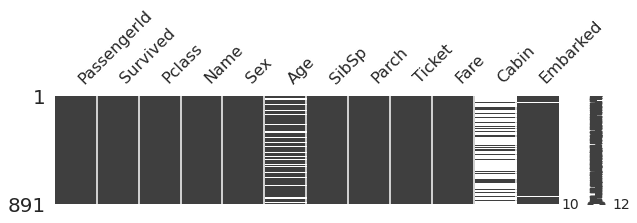

In [6]:
missingno.matrix(train, figsize=(10,2))

<AxesSubplot:>

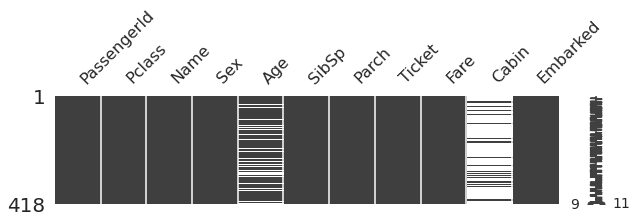

In [7]:
missingno.matrix(test, figsize=(10,2))

## Outlier detection

<AxesSubplot:>

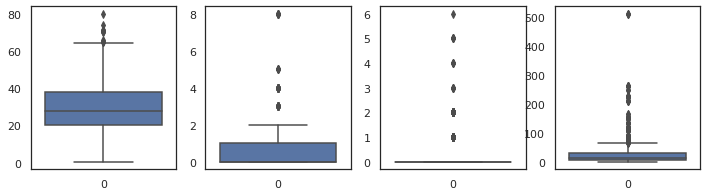

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12,3))
sns.boxplot(data=train["Age"],   orient='v', ax=ax[0])
sns.boxplot(data=train["SibSp"], orient='v', ax=ax[1])
sns.boxplot(data=train["Parch"], orient='v', ax=ax[2])
sns.boxplot(data=train["Fare"],  orient='v', ax=ax[3])

<AxesSubplot:xlabel='Fare', ylabel='Count'>

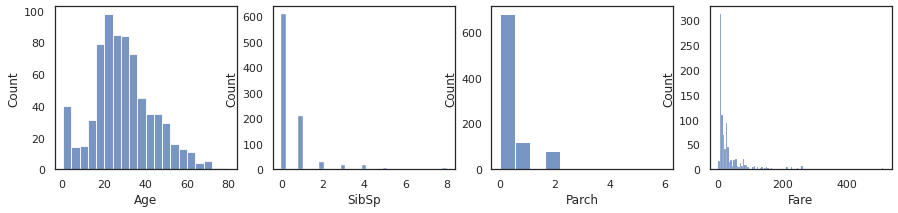

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,3))
sns.histplot(data=train["Age"],   ax=ax[0])
sns.histplot(data=train["SibSp"], ax=ax[1])
sns.histplot(data=train["Parch"], ax=ax[2])
sns.histplot(data=train["Fare"],  ax=ax[3])

In [10]:
# Outlier detection 

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])

In [11]:
print(Outliers_to_drop)

[27, 88, 159, 180, 201, 324, 341, 792, 846, 863]


In [12]:
train.loc[Outliers_to_drop] # Show the outliers rows

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


- Reference에서는 outlier를 drop하였으나, 여기에서는 drop하지 않는다. 

## Joining Train and Test sets for Data Manipulations

In [13]:
## Join train and test datasets in order to obtain the same number of features during categorical conversion
train_len = len(train)
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

In [14]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


<AxesSubplot:>

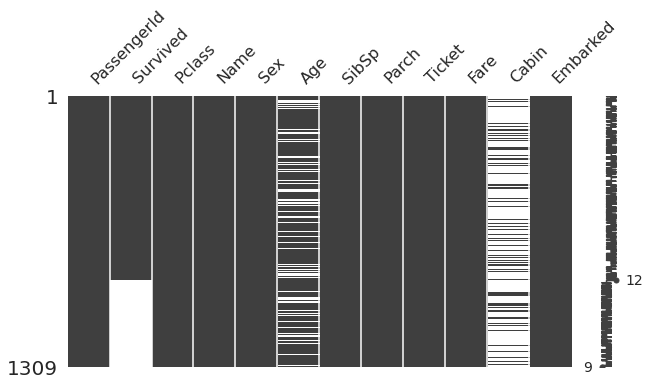

In [15]:
missingno.matrix(dataset, figsize=(10,5))

In [16]:
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

# Part 3. Data and Feature Analysis

## Numerical values

<AxesSubplot:>

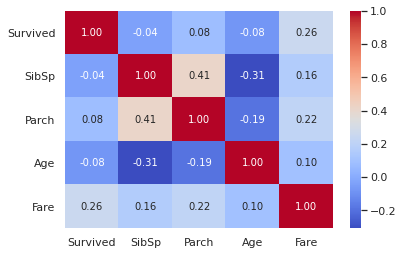

In [17]:
sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

- Fare has the highest correlation with Survived.

### SibSp (Sibling and Spouse) vs Survived

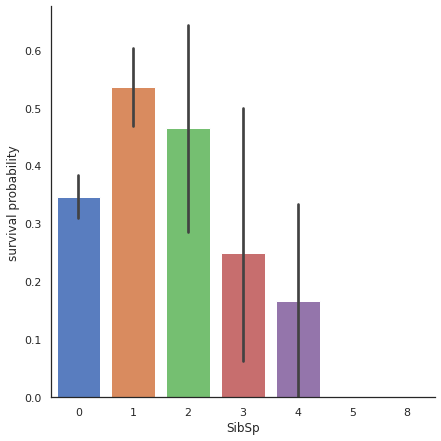

In [18]:
g = sns.catplot(x="SibSp", y="Survived", data=train, kind="bar", height=6, palette = "muted")
g.set_ylabels("survival probability")

### Parch (Parents and Children) vs Survived

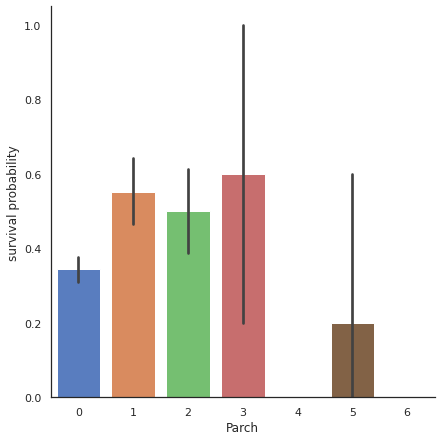

In [19]:
g = sns.catplot(x="Parch", y="Survived", data=train, kind="bar", height=6, palette = "muted")
g.set_ylabels("survival probability")

### Age vs Survived

Text(0.5, 1.0, 'Survived=1')

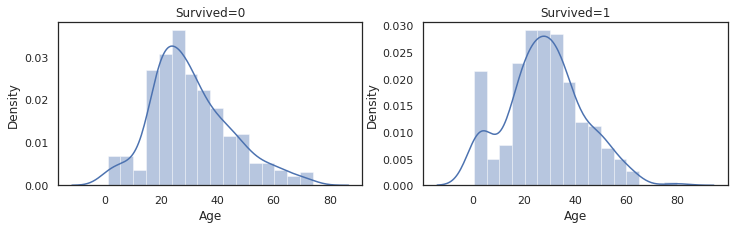

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,3))
sns.distplot(train[train['Survived']==0].Age, ax=ax[0])
sns.distplot(train[train['Survived']==1].Age, ax=ax[1])
ax[0].set_title("Survived=0")
ax[1].set_title("Survived=1")

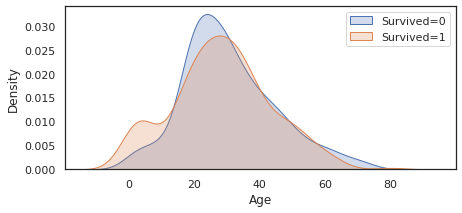

In [21]:
fig, ax = plt.subplots(figsize=(7,3))
sns.kdeplot(train[train['Survived']==0].Age, shade=True, ax=ax, label='Survived=0')
sns.kdeplot(train[train['Survived']==1].Age, shade=True, ax=ax, label='Survived=1')
ax.legend()

### Fare vs Survived

In [22]:
print(train["Fare"].isnull().sum())
print(test["Fare"].isnull().sum())

0
1


- Test data set has one missing value. We need to fill it out with some value. 

In [23]:
test.loc[test[test["Fare"].isnull()].index]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


- Test set의 이 승객(Storey Mr. Thomas)의 경우, Fare와 Cabin이 missing value이다. 
- Pclass와 Embarked 등으로 Fare 값을 추측할 필요가 있다. 

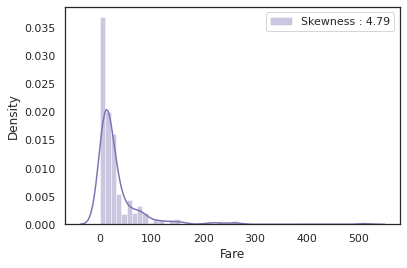

In [24]:
g = sns.distplot(train["Fare"], color="m", label="Skewness : %.2f"%(train["Fare"].skew()))
g.legend()

- Fare values have high skewness. It might be helpful to use logarithmic transformation in order to reduce skewness.

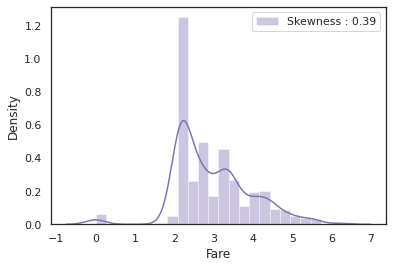

In [25]:
g = sns.distplot(np.log1p(train["Fare"]), color="m", label="Skewness : %.2f"%(np.log1p(train["Fare"]).skew()))
g.legend()

In [26]:
train[train["Fare"]==0]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S


In [27]:
test[test["Fare"]==0]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
266,1158,1,"Chisholm, Mr. Roderick Robert Crispin",male,NaN,0,0,112051,0.0,NaN,S
372,1264,1,"Ismay, Mr. Joseph Bruce",male,49.0,0,0,112058,0.0,B52 B54 B56,S


- Fare값이 0인 데이터들이 있다. 실제 무료로 탑승을 한 사람들인지 아니면 missing values인지 판단해야 한다. 

<AxesSubplot:xlabel='Fare', ylabel='Density'>

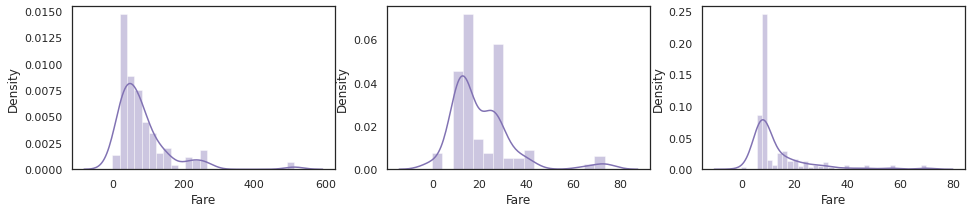

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,3))
sns.distplot(train[train["Pclass"]==1].Fare, color="m", ax=ax[0])
sns.distplot(train[train["Pclass"]==2].Fare, color="m", ax=ax[1])
sns.distplot(train[train["Pclass"]==3].Fare, color="m", ax=ax[2])

In [29]:
train[["Pclass", "Fare"]].groupby("Pclass").mean()

,Fare
Pclass,
1,84.154687
2,20.662183
3,13.675550


## Categorical Values

### Sex

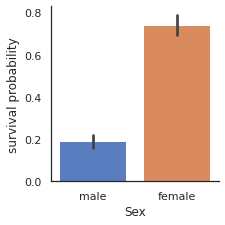

In [30]:
g = sns.catplot(x="Sex", y="Survived", data=train, kind="bar", height=3, palette = "muted")
g.set_ylabels("survival probability")

In [31]:
train[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.742038
male,0.188908


- 여성이 상대적으로 남성에 비해 생존율이 높았다. 
- 성별은 생존여부를 판단하는데 중요한 요소라고 생각할 수 있다. 

### Pclass

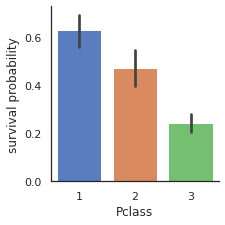

In [32]:
g = sns.catplot(x="Pclass", y="Survived", data=train, kind="bar", height=3, palette = "muted")
g.set_ylabels("survival probability")

In [33]:
train[['Pclass', 'Survived']].groupby('Pclass').mean()

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


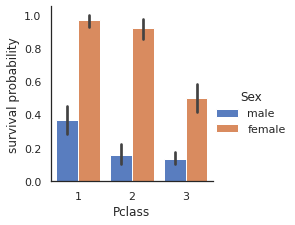

In [34]:
g = sns.catplot(x="Pclass", y="Survived", hue='Sex', data=train, kind="bar", height=3, palette = "muted")
g.set_ylabels("survival probability")

- 더 좋은 등급일수록 생존율이 높다. Pclass는 생존율을 예측하는데 매우 중요한 요소 중에 하나이다. 

### Embarked

In [35]:
print(dataset['Embarked'].isnull().sum())
print(train['Embarked'].isnull().sum())
print(test['Embarked'].isnull().sum())

2
2
0


In [36]:
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

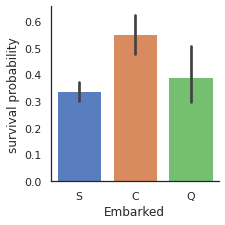

In [37]:
g = sns.catplot(x="Embarked", y="Survived", data=train, kind="bar", height=3, palette = "muted")
g.set_ylabels("survival probability")

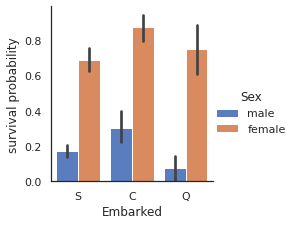

In [38]:
g = sns.catplot(x="Embarked", y="Survived", hue='Sex', data=train, kind="bar", height=3, palette = "muted")
g.set_ylabels("survival probability")

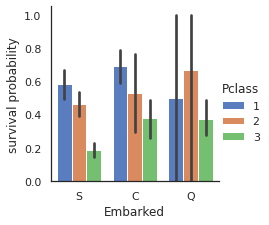

In [39]:
g = sns.catplot(x="Embarked", y="Survived", hue='Pclass', data=train, kind="bar", height=3, palette = "muted")
g.set_ylabels("survival probability")

In [40]:
train[train['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


- Embarked가 missing values인 두 명은 모두 1등급에 머무른 사람들이다. 

<AxesSubplot:xlabel='Embarked', ylabel='count'>

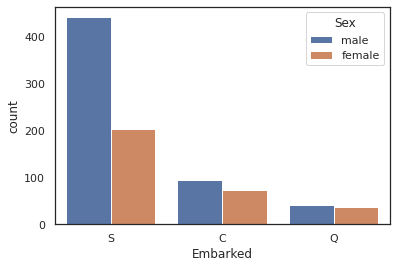

In [41]:
sns.countplot(data=train, x='Embarked', hue='Sex')

<AxesSubplot:xlabel='Embarked', ylabel='count'>

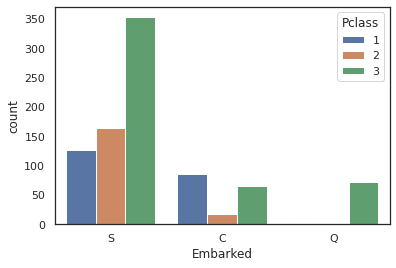

In [42]:
sns.countplot(data=train, x='Embarked', hue='Pclass')

- 1등객은 S와 C에서 탔으며 S에서 더 많은 1등객이 탔습니다. 
- 여성 손님은 S에서 더 많은 수가 탔습니다.

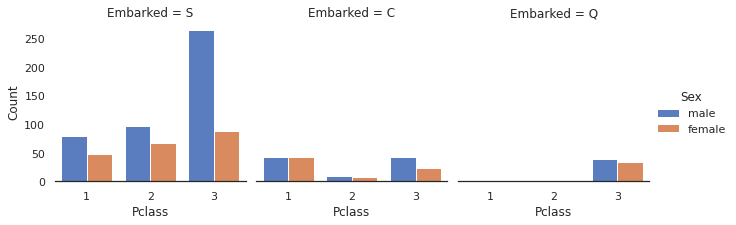

In [43]:
# Explore Pclass vs Embarked 
g = sns.factorplot("Pclass", col="Embarked",  hue='Sex', data=train, size=3, kind="count", palette="muted")
g.despine(left=True)
g = g.set_ylabels("Count")

- S와 C에서 탑승한 1등급 여성 승객의 수는 비슷해 보입니다. 

In [44]:
print(train[(train['Embarked']=='S') & (train['Pclass']==1) & (train['Sex']=='female')].Fare.mean())
print(train[(train['Embarked']=='S') & (train['Pclass']==1) & (train['Sex']=='female')].Fare.std())
print(train[(train['Embarked']=='C') & (train['Pclass']==1) & (train['Sex']=='female')].Fare.mean())
print(train[(train['Embarked']=='C') & (train['Pclass']==1) & (train['Sex']=='female')].Fare.std())

99.02691041666667
61.094406816479925
115.64030930232558
88.57164465794482


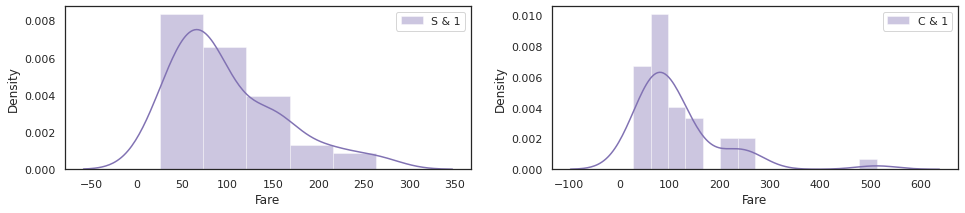

In [45]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,3))
sns.distplot(train[(train['Embarked']=='S') & (train['Pclass']==1) & (train['Sex']=='female')].Fare, 
             color="m", ax=ax[0], label="S & 1")
sns.distplot(train[(train['Embarked']=='C') & (train['Pclass']==1) & (train['Sex']=='female')].Fare, 
             color="m", ax=ax[1], label="C & 1")
ax[0].legend()
ax[1].legend()
plt.show()

- S와 C에서 탑승한 1등급 여승객의 Fare값으로는 구분하기 쉬워 보이지 않는다. 

## Name, Ticket, Cabin 

### Name

In [46]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


- Name에는 Missing value가 없습니다. 
- 각 Name string의 가운데에 있는 Title (ex. Mr)를 뽑아내어 Title이라는 feature로 만듭시다. 

In [47]:
dataset_title = [i.split(',')[1].split('.')[0].strip() for i in dataset['Name']]
dataset['Title'] = pd.Series(dataset_title)
dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [48]:
train_title = dataset.loc[:train_len-1]

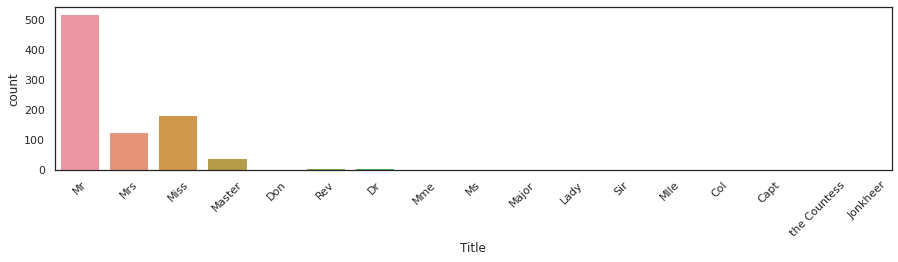

In [49]:
plt.figure(figsize=(15,3))
g = sns.countplot(data=train_title, x='Title')
g = plt.setp(g.get_xticklabels(), rotation=45) 
plt.show()

In [50]:
train_title['Title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Major             2
Col               2
Mlle              2
Lady              1
Ms                1
Don               1
Capt              1
Mme               1
Sir               1
Jonkheer          1
the Countess      1
Name: Title, dtype: int64

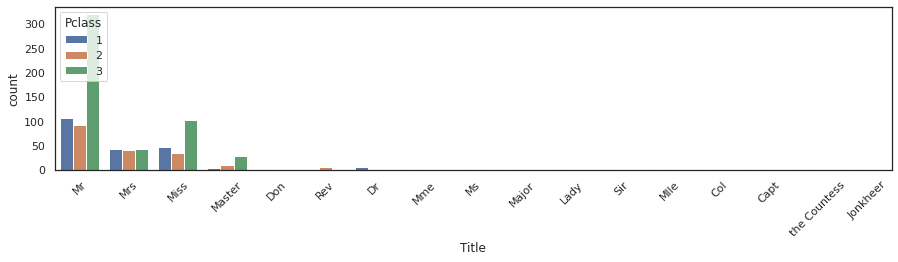

In [51]:
plt.figure(figsize=(15,3))
g = sns.countplot(data=train_title, x='Title', hue='Pclass')
g = plt.setp(g.get_xticklabels(), rotation=45) 
plt.show()

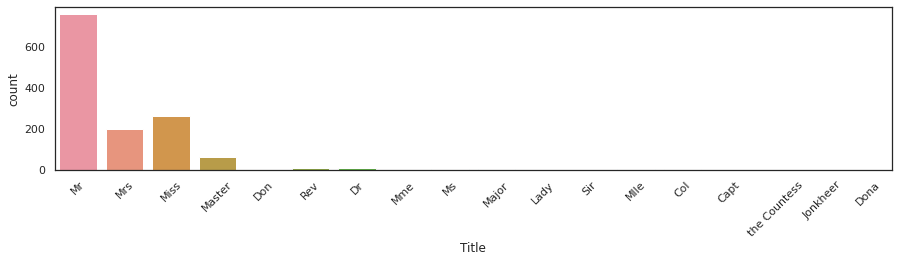

In [52]:
plt.figure(figsize=(15,3))
g = sns.countplot(data=dataset, x='Title')
g = plt.setp(g.get_xticklabels(), rotation=45) 
plt.show()

In [53]:
dataset['Title'].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Dr                8
Rev               8
Col               4
Ms                2
Mlle              2
Major             2
Don               1
Sir               1
the Countess      1
Lady              1
Capt              1
Mme               1
Dona              1
Jonkheer          1
Name: Title, dtype: int64

- 여성 호칭(Mrs, Miss, Ms, Mme, Mille)을 하나로 묶습니다. 
- 탑승객 수가 적은 호칭을 'Rare'로 하여 하나로 묶습니다. 

In [54]:
dataset["Title"] = dataset['Title'].replace(['Don', 'Rev', 'Dr', 'Major', 'Lady', 'Sir', 'Col', 'Capt', 
                                             'the Countess', 'Jonkheer', 'Dona'], 'Rare')

dataset["Title"].value_counts()

Mr        757
Miss      260
Mrs       197
Master     61
Rare       29
Ms          2
Mlle        2
Mme         1
Name: Title, dtype: int64

In [55]:
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1,
                                         "Mr":2, "Rare":3})
dataset['Title'].value_counts()

2    757
1    462
0     61
3     29
Name: Title, dtype: int64

In [150]:
train_title = dataset[:train_len]

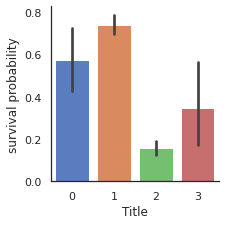

In [151]:
g = sns.catplot(x="Title", y="Survived", data=train_title, kind="bar", height=3, palette = "muted")
g.set_ylabels("survival probability")

- Master와 여성 승객들의 생존률이 남성 승객과 Rare 승객들보다 높습니다. 
- Rare 승객은 일반 남성 승객보다 높은 생존율을 보입니다. 

### Master?

<AxesSubplot:xlabel='Pclass', ylabel='count'>

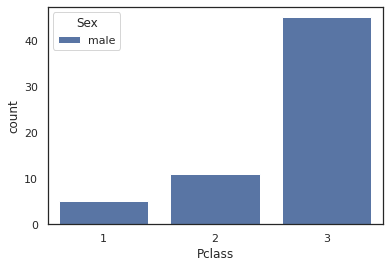

In [58]:
sns.countplot(data=dataset[dataset['Title']==0], x='Pclass', hue='Sex')

- 'Master'라는 Title을 가진 사람은 모두 남성(male)이며 1등급 승객이 대다수를 차지한다. 

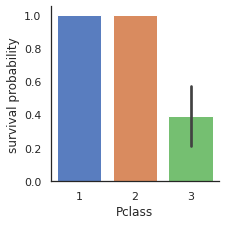

In [59]:
g = sns.catplot(x="Pclass", y="Survived", data=train_title[train_title['Title']==0], 
                kind="bar", height=3, palette = "muted")
g.set_ylabels("survival probability")

- 'Master'라는 호칭을 가진 사람들중 1등급과 2등급 승객들은 거의 100%에 가까운 생존률을 보였으며 3등급 승객들도 40%의 생존율을 보였다. 

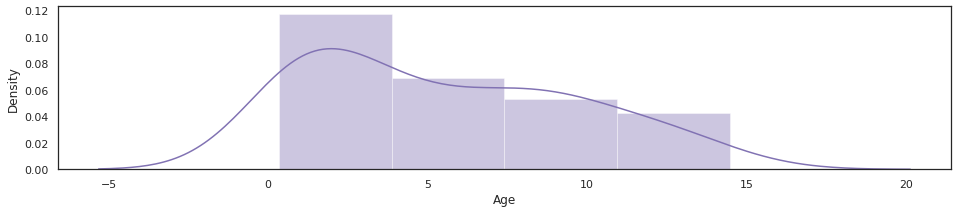

In [60]:
condition = dataset['Title']==0
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,3))
sns.distplot(dataset[condition].Age, color="m", ax=ax)
plt.show()

- Master 호칭을 가진 사람들은 15세 미만의 사람들이다.

### Rare?

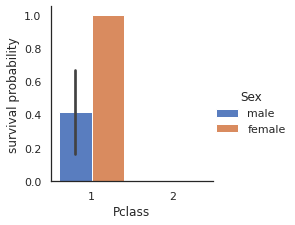

In [61]:
g = sns.catplot(x="Pclass", y="Survived", hue="Sex", data=train_title[train_title['Title']==3], kind="bar", 
                height=3, palette = "muted")
g.set_ylabels("survival probability")

<AxesSubplot:xlabel='Pclass', ylabel='count'>

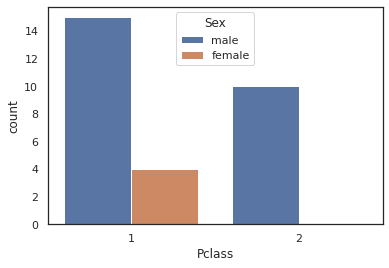

In [62]:
sns.countplot(data=dataset[dataset['Title']==3], x='Pclass', hue="Sex")

- Rare는 3등급 승객이 없습니다. 
- Rare의 여성승객은 100%에 가까운 생존율을 보였으며, Rare의 남성승객도 40%의 생존율을 보였습니다. 일반 남성의 생존율 20%에 비교하면 높은 생존율입니다. 

### Cabin

In [63]:
dataset['Cabin'].notnull().value_counts()

False    1014
True      295
Name: Cabin, dtype: int64

In [64]:
cabin_initial = dataset['Cabin'].str[0]

In [65]:
cabin_initial.value_counts()

C    94
B    65
D    46
E    41
A    22
F    21
G     5
T     1
Name: Cabin, dtype: int64

In [66]:
cabin_initial.count()

295

- missing values를 가지는 Cabin을 제외하면, 나머지 295개의 Cabin 데이터는 A, B, C, D, E, F, G, T라는 이니셜을 가집니다. 
- missing values를 가지는 Cabin에게는 X를 부여합니다. 

In [78]:
dataset["Cabin"].fillna('X', inplace=True)

In [81]:
dataset["Cabin"] = dataset['Cabin'].str[0]

In [82]:
dataset["Cabin"].value_counts()

X    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: Cabin, dtype: int64

<AxesSubplot:xlabel='Cabin', ylabel='count'>

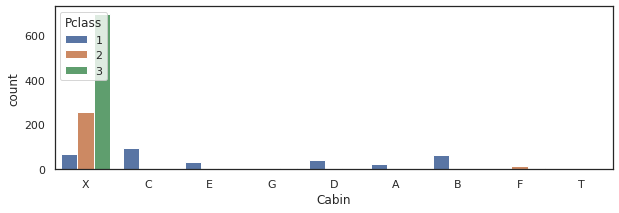

In [98]:
plt.figure(figsize=(10,3))
sns.countplot(data=dataset, x="Cabin", hue='Pclass')

<AxesSubplot:xlabel='Cabin', ylabel='count'>

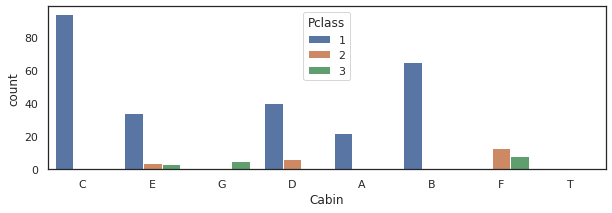

In [99]:
plt.figure(figsize=(10,3))
sns.countplot(data=dataset[dataset["Cabin"]!='X'], x="Cabin", hue='Pclass')

- Cabin A, B, C, D, E를 보면 1등급 승객이 대다수인 것을 알 수 있습니다. 
- F, G는 2, 3등급 승객으로 구성된 것으로 보입니다.
- T는 한 명으로 1등급 승객입니다. 
- missing value였던 Cabin X에 있던 승객을 2등급이나 3등급 승객이 투숙하는 Cabin이라고 할 수 있을까?

In [103]:
dataset['Pclass'].value_counts()

3    709
1    323
2    277
Name: Pclass, dtype: int64

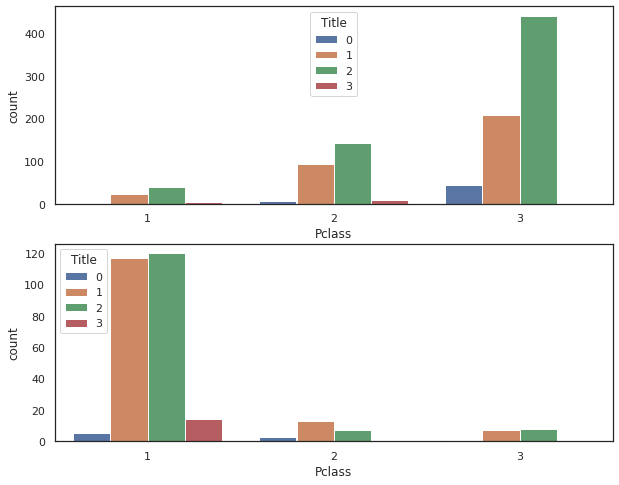

In [114]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,8))
sns.countplot(data=dataset[dataset["Cabin"]=='X'], x="Pclass", hue="Title", ax=ax[0])
sns.countplot(data=dataset[dataset["Cabin"]!='X'], x="Pclass", hue="Title", ax=ax[1])
plt.show()

In [109]:
print(dataset[(dataset['Pclass']==1) & (dataset['Cabin']=='X')].Cabin.count())
print(dataset[(dataset['Pclass']==1) & (dataset['Cabin']!='X')].Cabin.count())

67
256


In [110]:
print(dataset[(dataset['Pclass']==2) & (dataset['Cabin']=='X')].Cabin.count())
print(dataset[(dataset['Pclass']==2) & (dataset['Cabin']!='X')].Cabin.count())

254
23


In [111]:
print(dataset[(dataset['Pclass']==3) & (dataset['Cabin']=='X')].Cabin.count())
print(dataset[(dataset['Pclass']==3) & (dataset['Cabin']!='X')].Cabin.count())

693
16


- Cabin X에 2등급과 3등급 승객이 다수를 차지하는 것은 사실입니다. 
- 하지만, Cabin X의 67명은 1등급 승객입니다.  

In [116]:
print(dataset[(dataset['Pclass']==1) & (dataset['Cabin']=='F')].Cabin.count())
print(dataset[(dataset['Pclass']==1) & (dataset['Cabin']=='G')].Cabin.count())
print(dataset[(dataset['Pclass']==1) & (dataset['Cabin']=='T')].Cabin.count())

0
0
1


In [127]:
for cabin in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'X']:
    meanFare = dataset[dataset['Cabin']==cabin].Fare.mean()
    stdFare  = dataset[dataset['Cabin']==cabin].Fare.std()
    print("{0}:{1:10.2f}, {2:10.2f}".format(cabin, meanFare, stdFare))

A:     41.24,      20.14
B:    122.38,     115.31
C:    107.93,      72.91
D:     53.01,      28.13
E:     54.56,      37.74
F:     18.08,      12.22
G:     14.21,       3.42
T:     35.50,        nan
X:     19.13,      27.49


#### Cabin vs Survived

In [147]:
trainc = dataset[:train_len]

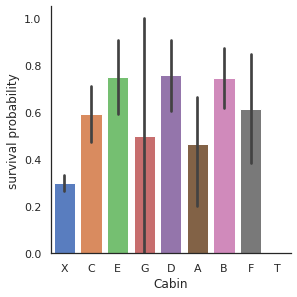

In [148]:
g = sns.catplot(x="Cabin", y="Survived", data=trainc, kind="bar", height=4, palette = "muted")
g.set_ylabels("survival probability")
plt.show()

- Cabin B, C, D, E의 경우 Cabin X보다는 생존율이 높습니다. 
- Cabin A, G, F의 경우에는 Std가 큰 값을 가지기 때문에, X의 생존율보다 높다고 결론내리기는 쉽지 않습니다. 

#### Conclusion

- Cabin을 feature로 사용할 수 있을까?

## Ticket

In [168]:
dataset['Ticket'][:20]

0            A/5 21171
1             PC 17599
2     STON/O2. 3101282
3               113803
4               373450
5               330877
6                17463
7               349909
8               347742
9               237736
10             PP 9549
11              113783
12           A/5. 2151
13              347082
14              350406
15              248706
16              382652
17              244373
18              345763
19                2649
Name: Ticket, dtype: object

In [169]:
dataset[dataset['Ticket'].str[0] == 'A'][:10]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,X,S,2
12,13,0.0,3,"Saundercock, Mr. William Henry",male,20.0,0,0,A/5. 2151,8.05,X,S,2
37,38,0.0,3,"Cann, Mr. Ernest Charles",male,21.0,0,0,A./5. 2152,8.05,X,S,2
51,52,0.0,3,"Nosworthy, Mr. Richard Cater",male,21.0,0,0,A/4. 39886,7.80,X,S,2
121,122,0.0,3,"Moore, Mr. Leonard Charles",male,NaN,0,0,A4. 54510,8.05,X,S,2
132,133,0.0,3,"Robins, Mrs. Alexander A (Grace Charity Laury)",female,47.0,1,0,A/5. 3337,14.50,X,S,1
152,153,0.0,3,"Meo, Mr. Alfonzo",male,55.5,0,0,A.5. 11206,8.05,X,S,2
153,154,0.0,3,"van Billiard, Mr. Austin Blyler",male,40.5,0,2,A/5. 851,14.50,X,S,2
204,205,1.0,3,"Cohen, Mr. Gurshon ""Gus""",male,18.0,0,0,A/5 3540,8.05,X,S,2
212,213,0.0,3,"Perkin, Mr. John Henry",male,22.0,0,0,A/5 21174,7.25,X,S,2


- 어떤 Ticket에는 Prefix (such as A/5, STON/02, etc.)가 붙어 있고 다른 Ticket에는 숫자만 적혀 있다. 
- Prefix가 의미하는 바를 파악하기 전에는 Ticket을 어떤 Feature로 써야 할지 명확하지 않다. 

# Part 4. Missing Value Manipulation

In [170]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        1309 non-null   object 
 11  Embarked     1307 non-null   object 
 12  Title        1309 non-null   int64  
dtypes: float64(3), int64(5), object(5)
memory usage: 133.1+ KB


In [176]:
dataset.isnull().sum()

PassengerId      0
Survived       418
Pclass           0
Name             0
Sex              0
Age            263
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin            0
Embarked         2
Title            0
dtype: int64

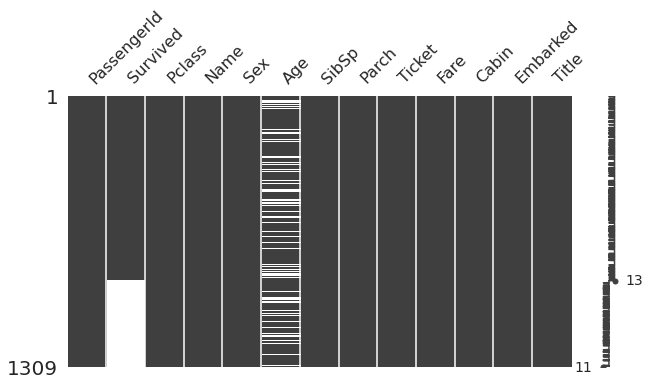

In [173]:
missingno.matrix(dataset, figsize=(10,5))
plt.show()

Missing Values
- Age     : 263개
- Fare    :   1개
- Embarked:   2개

Cabin에도 Missing value가 있었으나 X값으로 대체하였다. Feature로 사용할지 여부는 아직 결정하지 않았다. 

In [178]:
dataset[dataset['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B,NaN,1
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B,NaN,1


In [179]:
dataset[dataset['Fare'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
1043,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,X,S,2


- Fare의 Missing Value는 Test set에 존재한다. 
- Embarked의 Missing value 2개는 Train set에 존재한다. 

## 1. Fare Missing Value

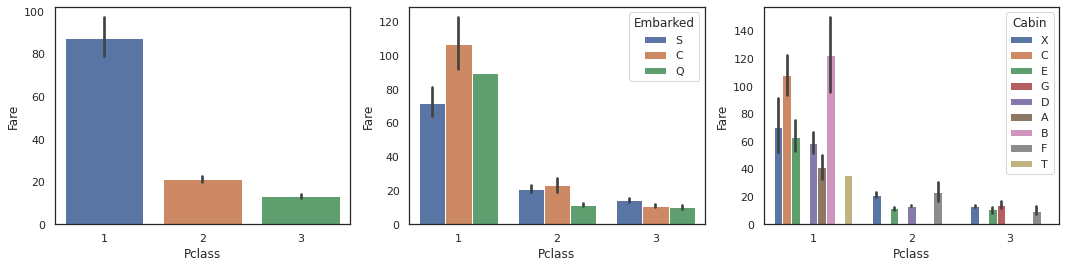

In [197]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,4))
sns.barplot(data=dataset, x="Pclass", y="Fare", ax=ax[0])
sns.barplot(data=dataset, x="Pclass", y="Fare", hue='Embarked', ax=ax[1])
sns.barplot(data=dataset, x="Pclass", y="Fare", hue='Cabin', ax=ax[2])
plt.show()

- Pclass 3의 Fare값의 평균은 약 10~20 사이에 있으며 표준편차가 작은 편이라 평균값을 사용할 수 있을 것이다. 
- Fare값이 Missing value인 PassengerId 1044인 남자의 Fare는 Pclass 3의 Fare 평균값으로 대체할 수 있다. 
- 또는 Pclass==3 & Embarked==S의 Fare 평균값으로 할 수도 있다. 

In [201]:
print(np.round(dataset[dataset['Pclass']==3].Fare.mean(),2))
print(np.round(dataset[(dataset['Pclass']==3) & (dataset['Embarked']=='S')].Fare.mean(),2))

13.3
14.44


In [202]:
FareMean_Pclass3 = dataset[dataset['Pclass']==3].Fare.mean()
dataset["Fare"].fillna(FareMean_Pclass3, inplace=True)

In [203]:
dataset["Fare"].isnull().sum()

0

## 2. Embarked Missing Values

- 1등급 손님은 C에서 많이 탄 것은 사실이나 S와 큰 격차를 보이지 않는다. 
- Embarked Missing value를 가지는 두 명의 여성 손님은 모두 1등급 손님이다. 
- C를 부여하는 방법을 생각할 수도 있거나 이 두 손님 데이터를 drop할 수도 있다. 

여기서는 C를 부여하도록 하자. 추후에 drop한 결과와 비교를 해보자. 

In [204]:
dataset["Embarked"].fillna('C', inplace=True)

In [207]:
dataset["Embarked"].isnull().sum()

0

## 3. Age Missing Values

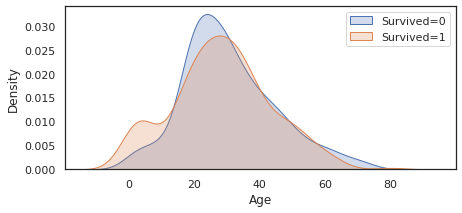

In [210]:
fig, ax = plt.subplots(figsize=(7,3))
sns.kdeplot(train[train['Survived']==0].Age, shade=True, ax=ax, label='Survived=0')
sns.kdeplot(train[train['Survived']==1].Age, shade=True, ax=ax, label='Survived=1')
ax.legend(); plt.show()

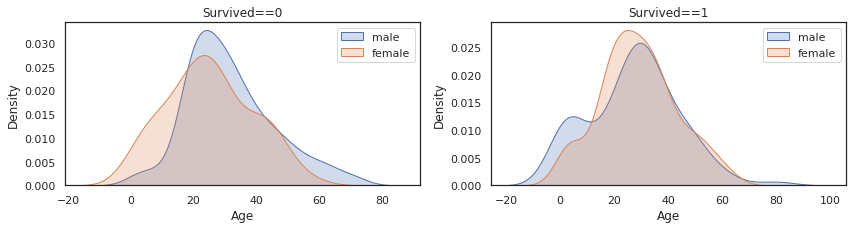

In [221]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(14,3))
ax0.set_title('Survived==0')
sns.kdeplot(train[(train['Survived']==0) & (train['Sex']=='male')].Age, shade=True, ax=ax0, label="male")
sns.kdeplot(train[(train['Survived']==0) & (train['Sex']=='female')].Age, shade=True, ax=ax0, label="female")
ax0.legend()

ax1.set_title('Survived==1')
sns.kdeplot(train[(train['Survived']==1) & (train['Sex']=='male')].Age, shade=True, ax=ax1, label="male")
sns.kdeplot(train[(train['Survived']==1) & (train['Sex']=='female')].Age, shade=True, ax=ax1, label="female")
ax1.legend(); 
plt.show()

- 생존여부에 따른 나이 분포에 차이가 있다. 
- 생존자의 경우, 나이가 어린 사람들이 많다. 
- 반면 20~30대에서 생존하지 못한 사람들이 많다.

- Title이 Master인 경우에는 10대이하이므로 Master중 missing value가 있는 경우에는 Master age 평균으로 채워넣을 수 있다. 
- 그러나 Master 중에는 Missing value가 없다. 


- Age의 경우, 많은 수의 Missing values(263개)가 존재한다. 적당한 Age값을 추측하는 것이 가능할까? 
- 평균값이나 중간값으로 대체하는 방법을 먼저 생각해볼 수 있다.
- 또는 회귀방법을 이용하여 Age값을 예측하는 방법을 생각할 수도 있다.



- Age를 예측하는 다른 Feature로는 가족과의 동승 여부를 생각할 수 있다. 다음과 같이 boxplot을 해보자.

Reference: https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling/notebook

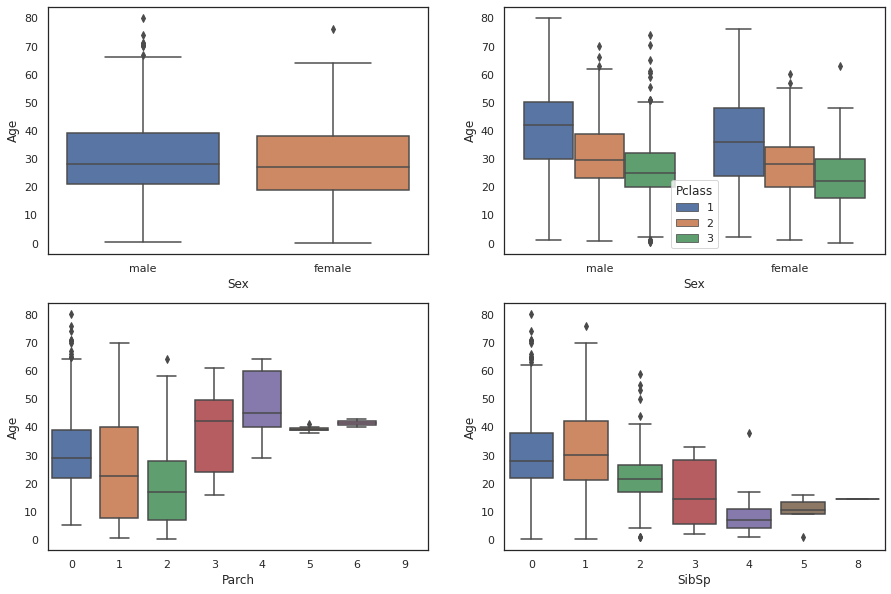

In [227]:
# Explore Age vs Sex, Parch , Pclass and SibSP
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
sns.boxplot(y="Age",x="Sex",data=dataset, ax=ax[0,0])
sns.boxplot(y="Age",x="Sex",hue="Pclass", data=dataset, ax=ax[0,1])
sns.boxplot(y="Age",x="Parch", data=dataset, ax=ax[1,0])
sns.boxplot(y="Age",x="SibSp", data=dataset, ax=ax[1,1])
plt.show()

- 남녀의 연령 분포는 거의 비슷하다. 
- 1등급, 2등급, 3등급 순으로 연령 분포가 젋어지는 것을 볼 수 있다. 
- Parch의 수가 늘어날수록 (Parch=4까지) 연령분포가 올라가는 것을 알 수 있다. 
- SibSp에서는 연령분포의 큰 차이가 없는 듯 하다. Sibsp>=4인 경우에는 연령대가 낮은 것은 알 수 있다. 

여기에서는 Age missing value는 Ref.를 따라서 생성하도록 한다. 

추후에 가능하면 Age를 예측하는 모델을 만들어 Age값을 생성하는 방법도 고려해보도록 하자. 


Ref:https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling/notebook

In [253]:
# Filling missing value of Age 

## Fill Age with the median age of similar rows according to Pclass, Parch and SibSp
# Index of NaN age rows
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"]) & (dataset['Parch'] == dataset.iloc[i]["Parch"]) & (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        dataset['Age'].iloc[i] = age_pred
    else :
        dataset['Age'].iloc[i] = age_med

In [254]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1309 non-null   float64
 10  Cabin        1309 non-null   object 
 11  Embarked     1309 non-null   object 
 12  Title        1309 non-null   int64  
 13  Family       1309 non-null   int64  
dtypes: float64(3), int64(6), object(5)
memory usage: 143.3+ KB


## 4. Family Feature?

Age를 예측하기 위하여 또는 새로운 Feature로 Family Feature를 추가할 수 있다. 

In [235]:
dataset["Family"] = dataset["SibSp"] + dataset["Parch"] + 1

In [236]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1309 non-null   float64
 10  Cabin        1309 non-null   object 
 11  Embarked     1309 non-null   object 
 12  Title        1309 non-null   int64  
 13  Family       1309 non-null   int64  
dtypes: float64(3), int64(6), object(5)
memory usage: 143.3+ KB


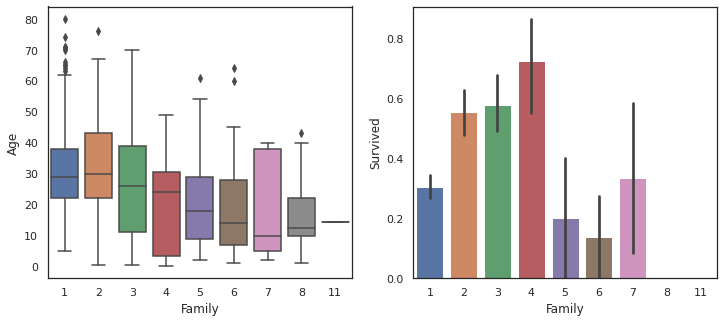

In [243]:
# Explore Age vs Family
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
sns.boxplot(y="Age",x="Family",data=dataset, ax=ax[0])
sns.barplot(y="Survived",x="Family",data=dataset[:train_len], ax=ax[1])
plt.show()

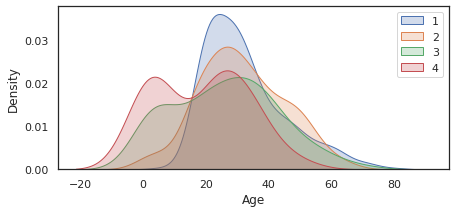

In [252]:
trainF = dataset[:train_len]
fig, ax = plt.subplots(figsize=(7,3))
for i in [1,2,3,4]:
    sns.kdeplot(trainF[trainF['Family']==i].Age, shade=True, ax=ax, label='{0}'.format(i))
    #sns.distplot(trainF[trainF['Family']==i].Age, ax=ax, label='{0}'.format(i))
ax.legend(); plt.show()

- Family수로 age를 예측하는 것은 쉬워보이지 않는다. 
- 다만, Family수와 생존율과는 유의미한 관계가 있어 보인다. 
- Family수가 1에서 4까지 증가함에 따라 생존율이 증가한다. 
- Family수가 더 증가하면 생존율은 급격하게 감소하는 경향을 보인다. 

Family size Feature를 숫자로 넣는 방법이 있고, 서너 개의 category로 나누는 방법도 가능할 것으로 보인다. 

Ref에서는 categorical feature로 처리를 하였다. 여기에서는 numerical feature로 처리를 해보도록 하겠다. 

## Conclusions

In [255]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1309 non-null   float64
 10  Cabin        1309 non-null   object 
 11  Embarked     1309 non-null   object 
 12  Title        1309 non-null   int64  
 13  Family       1309 non-null   int64  
dtypes: float64(3), int64(6), object(5)
memory usage: 143.3+ KB


# Part 5. Feature Selections

- Name, Ticket Features는 사용하지 않는다. 
- Cabin의 경우, 많은 Missing Value를 X로 대체하였다. X의 많은 수가 3등급 Cabin이기 때문에 어느 정도 의미있는 Feature라고 짐작할 수 있지만 확신할 수는 없다. Cabin을 사용하는 여부에 따른 두 가지 결과를 예측할 수 있다. 

In [256]:
dataset.drop(["Name", "Ticket"], axis=1, inplace=True)

In [257]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Sex          1309 non-null   object 
 4   Age          1309 non-null   float64
 5   SibSp        1309 non-null   int64  
 6   Parch        1309 non-null   int64  
 7   Fare         1309 non-null   float64
 8   Cabin        1309 non-null   object 
 9   Embarked     1309 non-null   object 
 10  Title        1309 non-null   int64  
 11  Family       1309 non-null   int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 122.8+ KB


- Pclass, Sex, Cabin, Embarked, Title은 Categorical Features이므로 One-Hot Encoding을 한다. 
- Fare의 경우 Standardization을 하되, log transformation을 하여 skewness를 줄인다. 

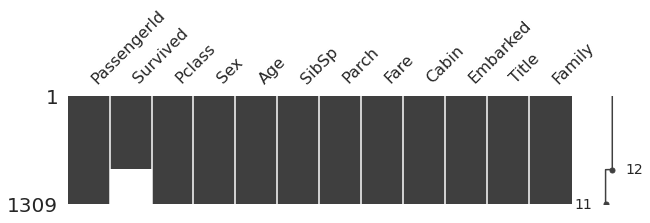

In [260]:
missingno.matrix(dataset, figsize=(10,2))
plt.show()